In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


In [ ]:
import tensorflow as tf

DATASET_SIZE = 234
train_size = int(0.65*DATASET_SIZE)
val_size = int(0.15*DATASET_SIZE)

data_dir_ap = '/content/gdrive/MyDrive/compound_img2/AP/'

train_val_ap_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_ap,
  validation_split=0.15,
  subset="training",
  seed=42)

test_ap_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_ap,
  validation_split=0.15,
  subset="validation",
  seed=42)

train_ap_ds = train_val_ap_ds.take(5)
validation_ap_ds = train_val_ap_ds.skip(5)


print("Number of training/val samples: %d" % tf.data.experimental.cardinality(train_val_ap_ds))
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ap_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ap_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ap_ds))


data_dir_L = '/content/gdrive/MyDrive/compound_img2/L/'

train_val_L_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_L,
  validation_split=0.15,
  subset="training",
  seed=42)

test_L_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_L,
  validation_split=0.15,
  subset="validation",
  seed=42)

train_L_ds = train_val_L_ds.take(5)
validation_L_ds = train_val_L_ds.skip(5)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_val_L_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_L_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_L_ds))




Found 234 files belonging to 2 classes.
Using 199 files for training.
Found 234 files belonging to 2 classes.
Using 35 files for validation.
Number of training/val samples: 7
Number of training samples: 5
Number of validation samples: 2
Number of test samples: 2
Found 234 files belonging to 2 classes.
Using 199 files for training.
Found 234 files belonging to 2 classes.
Using 35 files for validation.
Number of training samples: 7
Number of validation samples: 2
Number of test samples: 2


In [ ]:
size = (150, 150)

train_ap_ds = train_ap_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ap_ds = validation_ap_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ap_ds = test_ap_ds.map(lambda x, y: (tf.image.resize(x, size), y))

train_L_ds = train_L_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_L_ds = validation_L_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_L_ds = test_L_ds.map(lambda x, y: (tf.image.resize(x, size), y))


In [ ]:
x_train_ap = np.empty([1, 150, 150, 3])
y_train = []
for x,y in train_ap_ds:
  x_train_ap = np.concatenate((x_train_ap, x), axis=0)
  y_train = np.concatenate([y_train, y], axis=0)

x_train_ap = x_train_ap[1:, :,:,:]


x_val_ap = np.empty([1, 150, 150, 3])
y_val = []
for x,y in validation_ap_ds:
  x_val_ap = np.concatenate((x_val_ap, x), axis=0)
  y_val = np.concatenate([y_val, y], axis=0)

x_val_ap = x_val_ap[1:, :,:,:]

x_train_L = np.empty([1, 150, 150, 3])
y_train = []
for x,y in train_L_ds:
  x_train_L = np.concatenate((x_train_L, x), axis=0)
  y_train = np.concatenate([y_train, y], axis=0)

x_train_L = x_train_L[1:, :,:,:]

x_val_L = np.empty([1, 150, 150, 3])
y_val = []
for x,y in validation_L_ds:
  x_val_L = np.concatenate((x_val_L, x), axis=0)
  y_val = np.concatenate([y_val, y], axis=0)

x_val_L = x_val_L[1:, :,:,:]

x_test_ap = np.empty([1, 150, 150, 3])
y_test = []
for x,y in test_ap_ds:
  x_test_ap = np.concatenate((x_test_ap, x), axis=0)
  y_test = np.concatenate([y_test, y], axis=0)

x_test_ap = x_test_ap[1:, :,:,:]

x_test_L = np.empty([1, 150, 150, 3])
y_test = []
for x,y in test_L_ds:
  x_test_L = np.concatenate((x_test_L, x), axis=0)
  y_test = np.concatenate([y_test, y], axis=0)

x_test_L = x_test_L[1:, :,:,:]

In [ ]:
# batch_size = 32

# train_ap_ds = train_ap_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# train_L_ds = train_L_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# validation_ap_ds = validation_ap_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# validation_L_ds = validation_L_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# test_ap_ds = test_ap_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# test_L_ds = test_L_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation_ap = keras.Sequential(
    [
        layers .experimental.preprocessing.RandomFlip("horizontal"), #L -> R flip
        layers.experimental.preprocessing.RandomRotation(0.05),
    ]
)


data_augmentation_L = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"), #L -> R flip
        layers.experimental.preprocessing.RandomRotation(0.05),
    ]
)


In [ ]:
base_model_ap = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model_L = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.




83689472/83683744 [==============================] - 1s 0us/step


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
L_input (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
ap_input (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 150, 150, 3)  0           L_input[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 150, 150, 3)  0           ap_input[0][0]                   
____________________________________________________________________________________________

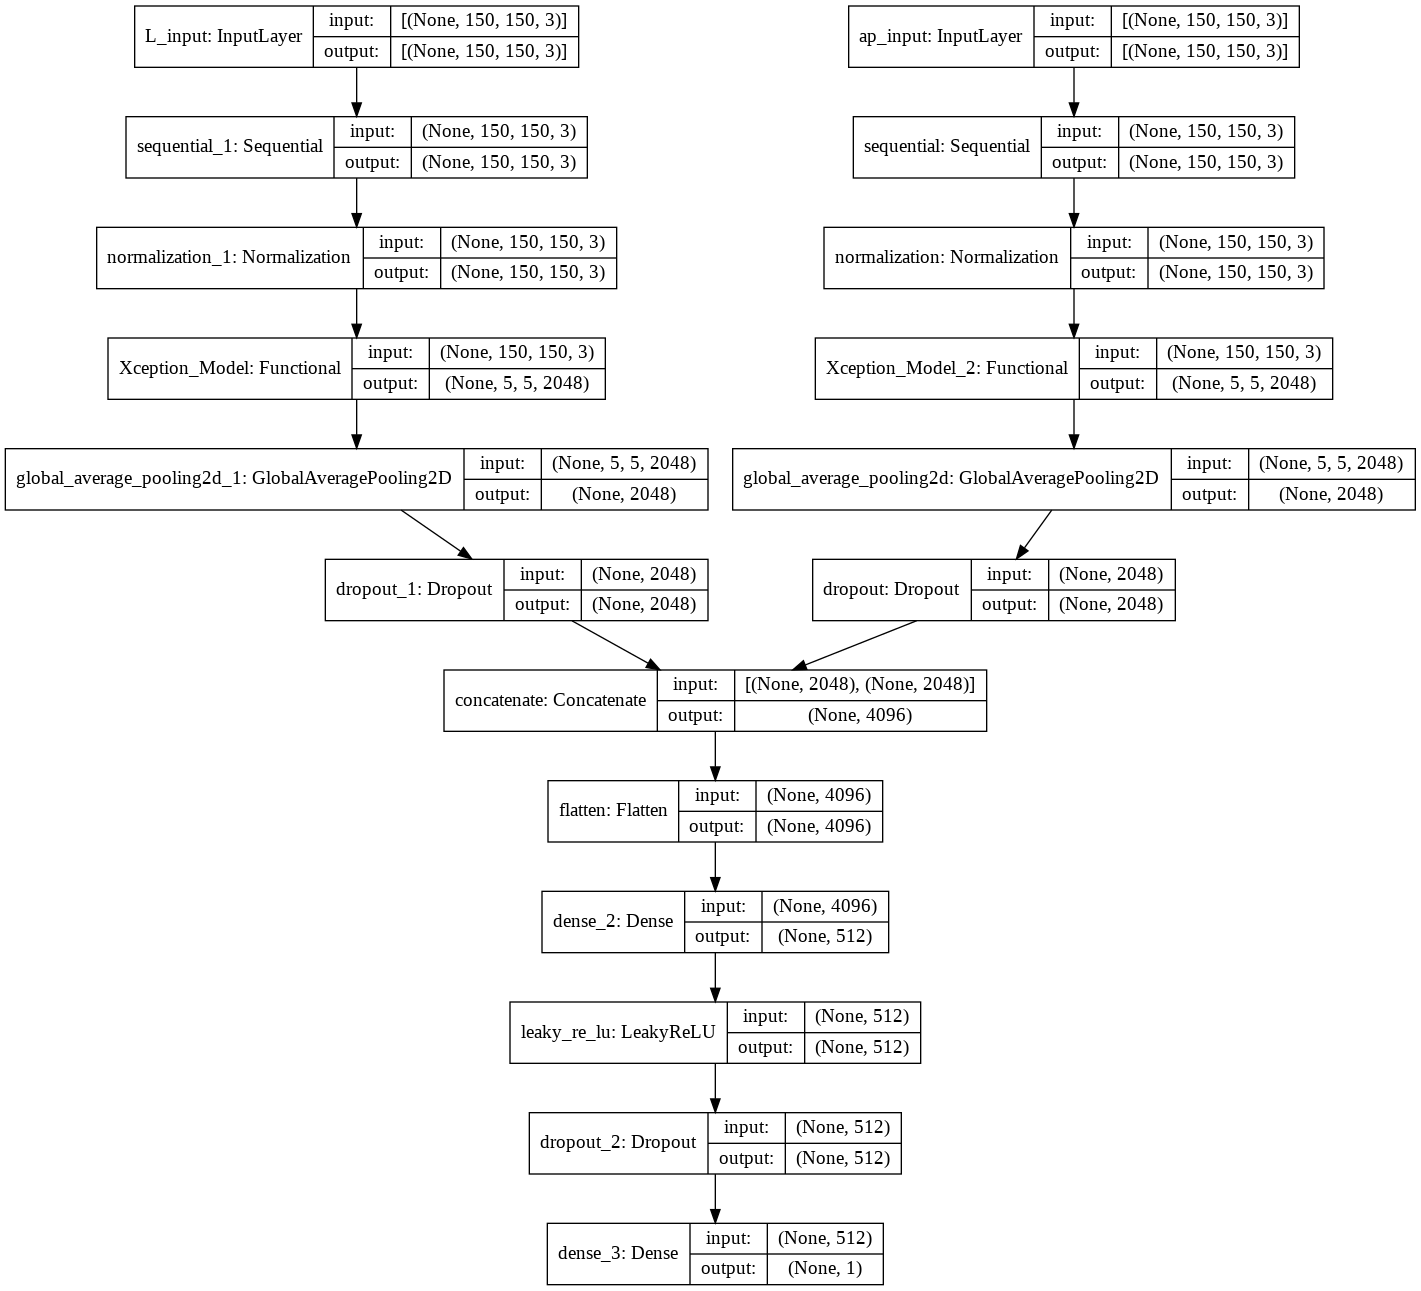

In [ ]:
import numpy as np 

base_model_ap.trainable = False
base_model_ap._name="Xception_Model_2"

inputs_ap = keras.Input(shape=(150, 150, 3) ,name="ap_input")
x_ap = data_augmentation_ap(inputs_ap)  

norm_layer_ap = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x_ap = norm_layer_ap(x_ap)
norm_layer_ap.set_weights([mean, var])

x_ap = base_model_ap(x_ap, training=False)

x_ap = keras.layers.GlobalAveragePooling2D()(x_ap)
x_ap = keras.layers.Dropout(0.2)(x_ap)  # Regularize with dropout
output_ap = keras.layers.Dense(1, activation='sigmoid')(x_ap)

model_ap = keras.Model(inputs_ap, output_ap)

keras.utils.plot_model(model_ap, "modelap.png", show_shapes=True)

# model_ap.summary()


#------Lateral View Model ----------

base_model_L.trainable = False
base_model_L._name="Xception_Model"

inputs_L = keras.Input(shape=(150, 150, 3), name="L_input")
x_L = data_augmentation_L(inputs_L)  

norm_layer_L = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x_L = norm_layer_L(x_L)
norm_layer_L.set_weights([mean, var])
x_L = base_model_L(x_L, training=False)


x_L = keras.layers.GlobalAveragePooling2D()(x_L)
x_L = keras.layers.Dropout(0.2)(x_L)  # Regularize with dropout
output_L = keras.layers.Dense(1, activation='sigmoid')(x_L)
model_L = keras.Model(inputs_L, output_L)
# model_L.summary()

keras.utils.plot_model(model_L, "modelL.png", show_shapes=True)


#-----------Combined Models ----------
cat = layers.concatenate([x_L, x_ap])

cat = layers.Flatten()(cat)

dense = layers.Dense(512)(cat)
dense = layers.LeakyReLU(alpha=0.1)(dense)
dense = layers.Dropout(0.5)(dense)
outputs = layers.Dense(1, activation='sigmoid')(dense)

# cat = keras.layers.GlobalAveragePooling2D()(cat)
# cat = keras.layers.Dropout(0.2)(cat)  # Regularize with dropout
# outputs = layers.Dense(1, activation='sigmoid')(cat)


model = keras.Model(
    inputs=[inputs_ap, inputs_L],
    outputs=outputs,
)
model.summary()

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)





In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model_ap.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

epochs = 100
model_ap.fit(x_train_ap, y=y_train, epochs=epochs, callbacks=[callback], validation_data=(x_val_ap, y_val))

Epoch 1/100
5/5 [==============================] - 37s 539ms/step - loss: 0.7293 - binary_accuracy: 0.4825 - auc: 0.5264 - val_loss: 0.6043 - val_binary_accuracy: 0.6410 - val_auc: 0.7179
Epoch 2/100
5/5 [==============================] - 0s 93ms/step - loss: 0.7139 - binary_accuracy: 0.5987 - auc: 0.5893 - val_loss: 0.5725 - val_binary_accuracy: 0.7179 - val_auc: 0.7888
Epoch 3/100
5/5 [==============================] - 0s 92ms/step - loss: 0.5921 - binary_accuracy: 0.6763 - auc: 0.7358 - val_loss: 0.5548 - val_binary_accuracy: 0.7692 - val_auc: 0.8235
Epoch 4/100
5/5 [==============================] - 0s 92ms/step - loss: 0.6159 - binary_accuracy: 0.6190 - auc: 0.6954 - val_loss: 0.5434 - val_binary_accuracy: 0.7692 - val_auc: 0.8610
Epoch 5/100
5/5 [==============================] - 0s 91ms/step - loss: 0.6122 - binary_accuracy: 0.6788 - auc: 0.7090 - val_loss: 0.5094 - val_binary_accuracy: 0.7949 - val_auc: 0.8570
Epoch 6/100
5/5 [==============================] - 0s 91ms/step - lo

In [ ]:
base_model_ap.trainable = True
model_ap.summary()

model_ap.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

epochs = 40
model_ap.fit(x_train_ap, y=y_train, epochs=epochs, callbacks=[callback], validation_data=(x_val_ap, y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ap_input (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
Xception_Model_2 (Functional (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [ ]:
model_ap.evaluate(x_test_ap, y=y_test)

2/2 [==============================] - 1s 512ms/step - loss: 0.6042 - binary_accuracy: 0.8286 - auc_1: 0.8799


[0.6042330265045166, 0.8285714387893677, 0.8799342513084412]

[3.3788863e-01 9.9930382e-01 9.0198114e-04 9.9976951e-01 7.9115637e-04
 6.5708696e-03 9.9797028e-01 9.9937743e-01 9.9932384e-01 9.8639584e-01
 9.9984717e-01 9.7462827e-01 1.3920589e-02 8.6298299e-01 1.5469284e-04
 6.7510086e-01 5.6841481e-01 9.9973315e-01 9.8511630e-01 9.9966383e-01
 5.9136893e-03 9.7267556e-01 5.0084639e-01 8.7919790e-01 1.3655430e-01
 9.9563700e-01 9.5759076e-01 1.5672902e-02 9.7798300e-01 9.9020213e-01
 2.8170547e-02 4.1943318e-03 5.2217650e-03 3.7627962e-01 1.0373209e-01]
[1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
-------------------
AUC: 0.8848684210526316
AUC COV: 0.0035595086949830714
95% AUC CI: [0.7679338 1.       ]

[1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]


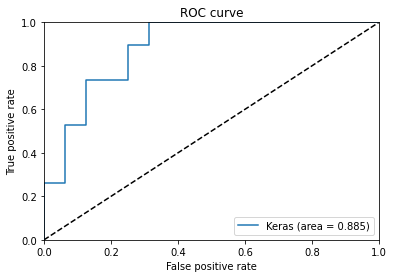

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred_ap = model_ap.predict(x_test_ap).ravel()
print(y_pred_ap)


# y_test = np.concatenate([y for x, y in test_ap_ds], axis=0)
print(y_test)

fpr_keras_ap, tpr_keras_ap, thresholds_keras = roc_curve(y_test, y_pred_ap)
auc_keras_ap = roc_auc_score(y_test, y_pred_ap)


print("-------------------")
alpha = .95
y_true = y_test
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred_ap)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)
print()



print(y_test)

plt.figure(1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_ap, tpr_keras_ap, label='Keras (area = {:.3f})'.format(auc_keras_ap))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
y_test

In [ ]:
model_L.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

epochs = 400
model_L.fit(x_train_L, y=y_train, epochs=epochs,  callbacks=[callback], validation_data=(x_val_L, y_val))

Epoch 1/400
5/5 [==============================] - 4s 311ms/step - loss: 0.8479 - binary_accuracy: 0.4764 - auc_2: 0.4445 - val_loss: 0.6408 - val_binary_accuracy: 0.5897 - val_auc_2: 0.7059
Epoch 2/400
5/5 [==============================] - 0s 89ms/step - loss: 0.6603 - binary_accuracy: 0.5671 - auc_2: 0.6972 - val_loss: 0.6269 - val_binary_accuracy: 0.6410 - val_auc_2: 0.7754
Epoch 3/400
5/5 [==============================] - 0s 89ms/step - loss: 0.6187 - binary_accuracy: 0.7411 - auc_2: 0.7244 - val_loss: 0.5675 - val_binary_accuracy: 0.7949 - val_auc_2: 0.8222
Epoch 4/400
5/5 [==============================] - 0s 90ms/step - loss: 0.5705 - binary_accuracy: 0.7223 - auc_2: 0.7761 - val_loss: 0.5212 - val_binary_accuracy: 0.8205 - val_auc_2: 0.8516
Epoch 5/400
5/5 [==============================] - 0s 90ms/step - loss: 0.5760 - binary_accuracy: 0.6673 - auc_2: 0.7855 - val_loss: 0.5004 - val_binary_accuracy: 0.7949 - val_auc_2: 0.8556
Epoch 6/400
5/5 [==============================] 

In [ ]:
base_model_L.trainable = True
model_L.summary()

model_L.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

epochs = 40
model_L.fit(x_train_L, y=y_train, epochs=epochs,  callbacks=[callback], validation_data=(x_val_L, y_val))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L_input (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
Xception_Model (Functional)  (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

In [ ]:
model_L.evaluate(x_test_L, y=y_test)

2/2 [==============================] - 0s 19ms/step - loss: 1.2025 - binary_accuracy: 0.7714 - auc_3: 0.8257


[1.2025092840194702, 0.7714285850524902, 0.825657844543457]

[7.5097173e-02 9.9997044e-01 1.0035126e-05 4.4058882e-02 1.8486344e-03
 8.6587381e-01 9.9999821e-01 7.2145927e-01 8.4048712e-01 9.5157546e-01
 9.9987733e-01 9.9392021e-01 9.9999845e-01 9.9632370e-01 7.7641103e-05
 9.9999928e-01 1.9448219e-01 9.9994600e-01 2.1005670e-02 9.9710780e-01
 2.4582868e-04 9.9995589e-01 9.5179963e-01 9.9998319e-01 9.9996173e-01
 9.9998689e-01 9.6009576e-01 3.1774677e-04 8.7240696e-01 9.9764001e-01
 5.6364690e-05 3.5754915e-03 8.5207087e-04 2.1905299e-01 5.5400087e-06]
[1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
-------------------
AUC: 0.8223684210526316
AUC COV: 0.006621748999692212
95% AUC CI: [0.66287806 0.98185878]



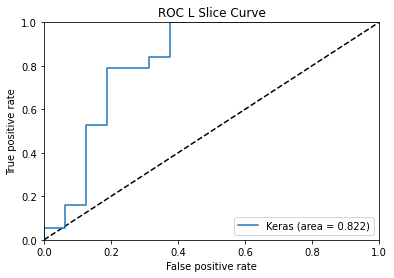

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt


y_pred_L = model_L.predict(x_test_L).ravel()
print(y_pred_L)
print(y_test)

fpr_keras_L, tpr_keras_L, thresholds_keras = roc_curve(y_test, y_pred_L)
auc_keras_L = roc_auc_score(y_test, y_pred_L)


print("-------------------")
alpha = .95
y_true = y_test
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred_L)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)
print()


plt.figure(1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_L, tpr_keras_L, label='Keras (area = {:.3f})'.format(auc_keras_L))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC L Slice Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
base_model_ap.trainable = False
base_model_L.trainable = False
model_ap.summary()
model_L.summary()


print("data loaded")

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


print("model loaded")
epochs = 200
model.fit(x=[x_train_ap, x_train_L],y=y_train , callbacks=[callback], epochs=epochs, validation_data=([x_val_ap, x_val_L], y_val))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ap_input (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
Xception_Model_2 (Functional (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [ ]:

model.evaluate(x=[x_test_ap, x_test_L], y=y_test)
model.evaluate(x=[x_val_ap, x_val_L], y=y_val)

2/2 [==============================] - 0s 41ms/step - loss: 0.0512 - binary_accuracy: 0.9744 - auc_4: 1.0000


[0.05120382085442543, 0.9743589758872986, 1.0]

[7.4254785e-04 1.0000000e+00 3.4898623e-12 9.3997735e-01 1.9241888e-08
 2.4205104e-01 1.0000000e+00 9.9957854e-01 9.9999809e-01 9.9718982e-01
 1.0000000e+00 9.9969852e-01 9.9999988e-01 9.8672247e-01 6.5471031e-11
 1.0000000e+00 7.8159040e-03 1.0000000e+00 6.8693695e-04 1.0000000e+00
 2.3812725e-09 1.0000000e+00 9.0584850e-01 9.9999726e-01 9.9994349e-01
 1.0000000e+00 9.8769462e-01 1.4531295e-06 9.9996889e-01 9.9999976e-01
 3.6468714e-10 1.2265650e-08 4.2281581e-08 6.6622496e-02 5.9717951e-09]
[1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
-------------------
AUC: 0.8717105263157894
AUC COV: 0.0037865016158818094
95% AUC CI: [0.75110501 0.99231604]



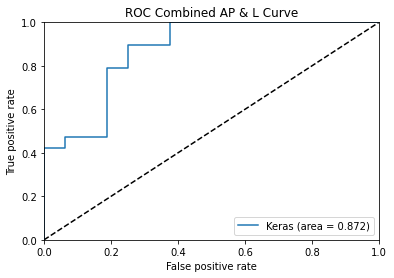

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt


y_pred = model.predict([x_test_ap, x_test_L]).ravel()
print(y_pred)
print(y_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = roc_auc_score(y_test, y_pred)


print("-------------------")
alpha = .95
y_true = y_test
auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)
print()


plt.figure(1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Combined AP & L Curve')
plt.legend(loc='best')
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, accuracy_score, average_precision_score, precision_score, recall_score, make_scorer, roc_curve, precision_recall_curve, average_precision_score, auc
plt.show()

In [ ]:

y_pred_ap = np.array([(3.6624223*(10**(-1))), (9.9950147*(10**(-1))), (3.5865660*(10**(-4))), (9.9997830*(10**(-1))), (1.2313364*(10**(-4))),
 (2.8107238*(10**(-3))), (9.9952364*(10**(-1))), (9.9995196*(10**(-1))), (9.9940991*(10**(-1))), (9.9262333*(10**(-1))),
 (9.9997795*(10**(-1))), (9.7417396*(10**(-1))), (6.3659893*(10**(-3))), (1.5652603*(10**(-4))),
 (4.0776229*(10**(-1))), (4.2752302*(10**(-1))), (9.9988151*(10**(-1))), (9.5007294*(10**(-1))), (9.9996769*(10**(-1))),
 (1.6873915*(10**(-3))), (9.9118453*(10**(-1))), (9.5909947*(10**(-1))), (9.6677899*(10**(-1))), (1.8138354*(10**(-1))),
 (9.9732435*(10**(-1))), (9.9635541*(10**(-1))), (1.3014897*(10**(-2))), (9.9177563*(10**(-1))), (9.8536009*(10**(-1))),
 (5.8756839*(10**(-2))), (2.9295119*(10**(-3))), (5.2006966*(10**(-3))), (7.9482652*(10**(-2))), (2.3373567*(10**(-2)))])

y_pred_L = np.array([(2.5614114*(10**(-2))), (9.9996614*(10**(-1))), (7.5411788*(10**(-7))), (6.4181276*(10**(-3))), (1.6263090*(10**(-3))),
 (9.2851299*(10**(-1))), (9.9999988*(10**(-1))), (3.9404026*(10**(-1))), (8.3951908*(10**(-1))), (9.4622850*(10**(-1))),
 (9.9923074*(10**(-1))), (9.9465770*(10**(-1))), (9.9999988*(10**(-1))), (3.3145743*(10**(-6))),
 (9.9999964*(10**(-1))), (2.6239049*(10**(-1))), (9.9996781*(10**(-1))), (6.0939081*(10**(-3))), (9.9977893*(10**(-1))),
 (2.0852171*(10**(-4))), (9.9997866*(10**(-1))), (8.8686699*(10**(-1))), (9.9999714*(10**(-1))), (9.9996006*(10**(-1))),
 (9.9999535*(10**(-1))), (9.7105128*(10**(-1))), (8.5999745*(10**(-5))), (8.7130427*(10**(-1))), (9.9953902*(10**(-1))),
 (1.5511689*(10**(-5))), (1.5765588*(10**(-3))), (1.7284905*(10**(-4))), (9.5304586*(10**(-2))), (2.2020824*(10**(-6)))])

y_pred= np.array([(7.4254785*(10**(-4))), (1.0000000*(10**(0))), (3.4898623*(10**(-2))), (9.3997735*(10**(-1))), (1.9241888*(10**(-8))),
 (2.4205104*(10**(-1))), (1.0000000*(10**(0))), (9.9957854*(10**(-1))), (9.9999809*(10**(-1))), (9.9718982*(10**(-1))),
 (1.0000000*(10**(0))), (9.9969852*(10**(-1))), (9.9999988*(10**(-1))), (6.5471031*(10**(-1))),
 (1.0000000*(10**(0))), (7.8159040*(10**(-3))), (1.0000000*(10**(0))), (6.8693695*(10**(-4))), (1.0000000*(10**(0))),
 (2.3812725*(10**(-9))), (1.0000000*(10**(0))), (9.0584850*(10**(-1))), (9.9999726*(10**(-1))), (9.9994349*(10**(-1))),
 (1.0000000*(10**(0))), (9.8769462*(10**(-1))), (1.4531295*(10**(-6))), (9.9996889*(10**(-1))), (9.9999976*(10**(-1))),
 (3.6468714*(10**(-10))), (1.2265650*(10**(-8))), (4.2281581*(10**(-8))), (6.6622496*(10**(-2))), (5.9717951*(10**(-9)))])
    
    
    

y_test = np.array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 
                   1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0])



In [ ]:


comparison = y_pred_rounded

for i in range(len(y_test)):
  if(y_test[i] == 0 and  comparison[i] == 1):
    print("--------------")
    print("False Positive")
    print("Index: " , i)
  if(y_test[i] == 1 and  comparison[i] == 0):
    print("--------------")
    print("False Negative")
    print("Index: " , i)



--------------
False Negative
Index:  0
--------------
False Positive
Index:  8
--------------
False Positive
Index:  12
--------------
False Positive
Index:  13
--------------
False Negative
Index:  15
--------------
False Positive
Index:  22


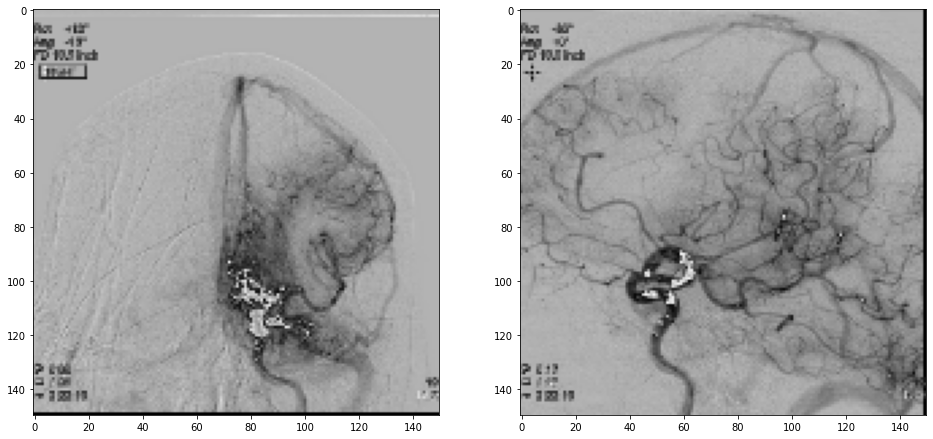

In [ ]:
index_of_miss = 23

fig, ax = plt.subplots(ncols=2, figsize=(16,10))

ap_miss = x_test_ap[index_of_miss]
ax[0].imshow((ap_miss).astype(np.uint8))
L_miss = x_test_L[index_of_miss]
ax[1].imshow((L_miss).astype(np.uint8))

plt.savefig("False_Positive_Index23.png")


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, accuracy_score, average_precision_score, precision_score, recall_score, make_scorer, roc_curve, precision_recall_curve, average_precision_score, auc


y_pred_ap_rounded = y_pred_ap.round()
y_pred_L_rounded = y_pred_L.round()
y_pred_rounded = y_pred.round()





#AUROC
print(" ---------------------------------- ")
print("AUROC Scores")
print("AUROC AP: ", roc_auc_score(y_test, y_pred_ap))

alpha = .95
auc, auc_cov = delong_roc_variance(y_test, y_pred_ap)
auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('95% AUC CI:', ci)

print("AUROC L: " , roc_auc_score(y_test, y_pred_L ))

auc, auc_cov = delong_roc_variance(y_test, y_pred_L)
auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('95% AUC CI:', ci)

print("AUROC Combined: ", roc_auc_score(y_test, y_pred))


auc, auc_cov = delong_roc_variance(y_test, y_pred)
auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('95% AUC CI:', ci)







#Accuracy
print(" ---------------------------------- ")
print("Accuracy Scores")
print("Accuracy AP: ", accuracy_score(y_test, y_pred_ap_rounded))
print("Accuracy L: " , accuracy_score(y_test, y_pred_L_rounded ))
print("Accuracy Combined: ", accuracy_score(y_test, y_pred_rounded))

#Precision Scores
print(" ---------------------------------- ")
print("Precision Scores")
print("Precision AP: ", precision_score(y_test, y_pred_ap_rounded))
print("Precision L: " , precision_score(y_test, y_pred_L_rounded ))
print("Precision Combined: ", precision_score(y_test, y_pred_rounded))



#Sensitivity Scores
print(" ---------------------------------- ")
print("Sensitivity Scores")
print("Sensitivity AP: ", recall_score(y_test, y_pred_ap_rounded))
print("Sensitivity L: " , recall_score(y_test, y_pred_L_rounded ))
print("Sensitivity Combined: ", recall_score(y_test, y_pred_rounded))


#AUPRC
print(" ---------------------------------- ")
print("AUPRC Scores")
print("AUPRC AP: ", average_precision_score(y_test, y_pred_ap_rounded))
print("AUPRC L: " , average_precision_score(y_test, y_pred_L_rounded ))
print("AUPRC Combined: ", average_precision_score(y_test, y_pred_rounded))



tn_ap, fp_ap, fn_ap, tp_ap = confusion_matrix(y_test, y_pred_ap_rounded).ravel()
tn_L, fp_L, fn_L, tp_L = confusion_matrix(y_test, y_pred_L_rounded ).ravel()
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rounded).ravel()


#NPV
print(" ---------------------------------- ")
print("NPV Scores")
print("NPV AP: ", tp_ap / (tp_ap + fp_ap))
print("NPV L: " , tp_L / (tp_L + fp_L))
print("NPV Combined: ", tp / (tp + fp))



#TPV
print(" ---------------------------------- ")
print("TPV Scores")
print("TPV AP: ", tn_ap / (tn_ap + fn_ap))
print("TPV L: " , tn_L / (tn_L + fn_L))
print("TPV Combined: ", tn / (tn + fn))



#Specificity
print(" ---------------------------------- ")
print("Specificity Scores")
print("Specificity AP: ", tn_ap / (tn_ap + fp_ap))
print("Specificity L: " , tn_L / (tn_L + fp_L))
print("Specificity Combined: ", tn / (tn + fp))



#F1-Score
print(" ---------------------------------- ")
print("F1 Scores")
print("F1 AP: ", f1_score(y_test, y_pred_ap_rounded))
print("F1 L: " , f1_score(y_test, y_pred_L_rounded ))
print("F1 Combined: ", f1_score(y_test, y_pred_rounded))








 ---------------------------------- 
AUROC Scores
AUROC AP:  0.9263157894736842
95% AUC CI: [0.8310677 1.       ]
AUROC L:  0.8333333333333334
95% AUC CI: [0.66443857 1.        ]
AUROC Combined:  0.8631578947368421
95% AUC CI: [0.73478891 0.99152688]
 ---------------------------------- 
Accuracy Scores
Accuracy AP:  0.7941176470588235
Accuracy L:  0.7647058823529411
Accuracy Combined:  0.8235294117647058
 ---------------------------------- 
Precision Scores
Precision AP:  0.8333333333333334
Precision L:  0.7894736842105263
Precision Combined:  0.8095238095238095
 ---------------------------------- 
Sensitivity Scores
Sensitivity AP:  0.7894736842105263
Sensitivity L:  0.7894736842105263
Sensitivity Combined:  0.8947368421052632
 ---------------------------------- 
AUPRC Scores
AUPRC AP:  0.7755417956656347
AUPRC L:  0.7409157568844713
AUPRC Combined:  0.7831343063541206
 ---------------------------------- 
NPV Scores
NPV AP:  0.8333333333333334
NPV L:  0.7894736842105263
NPV Combined: 

In [ ]:
fpr_ap, tpr_ap, thresholds_ap = roc_curve(y_test, y_pred_ap)
auc_ap = roc_auc_score(y_test, y_pred_ap)

fpr_L, tpr_L, thresholds_L = roc_curve(y_test, y_pred_L)
auc_L = roc_auc_score(y_test, y_pred_L)


fpr_combined, tpr_combined, thresholds_combined = roc_curve(y_test, y_pred)
auc_combined = roc_auc_score(y_test, y_pred)

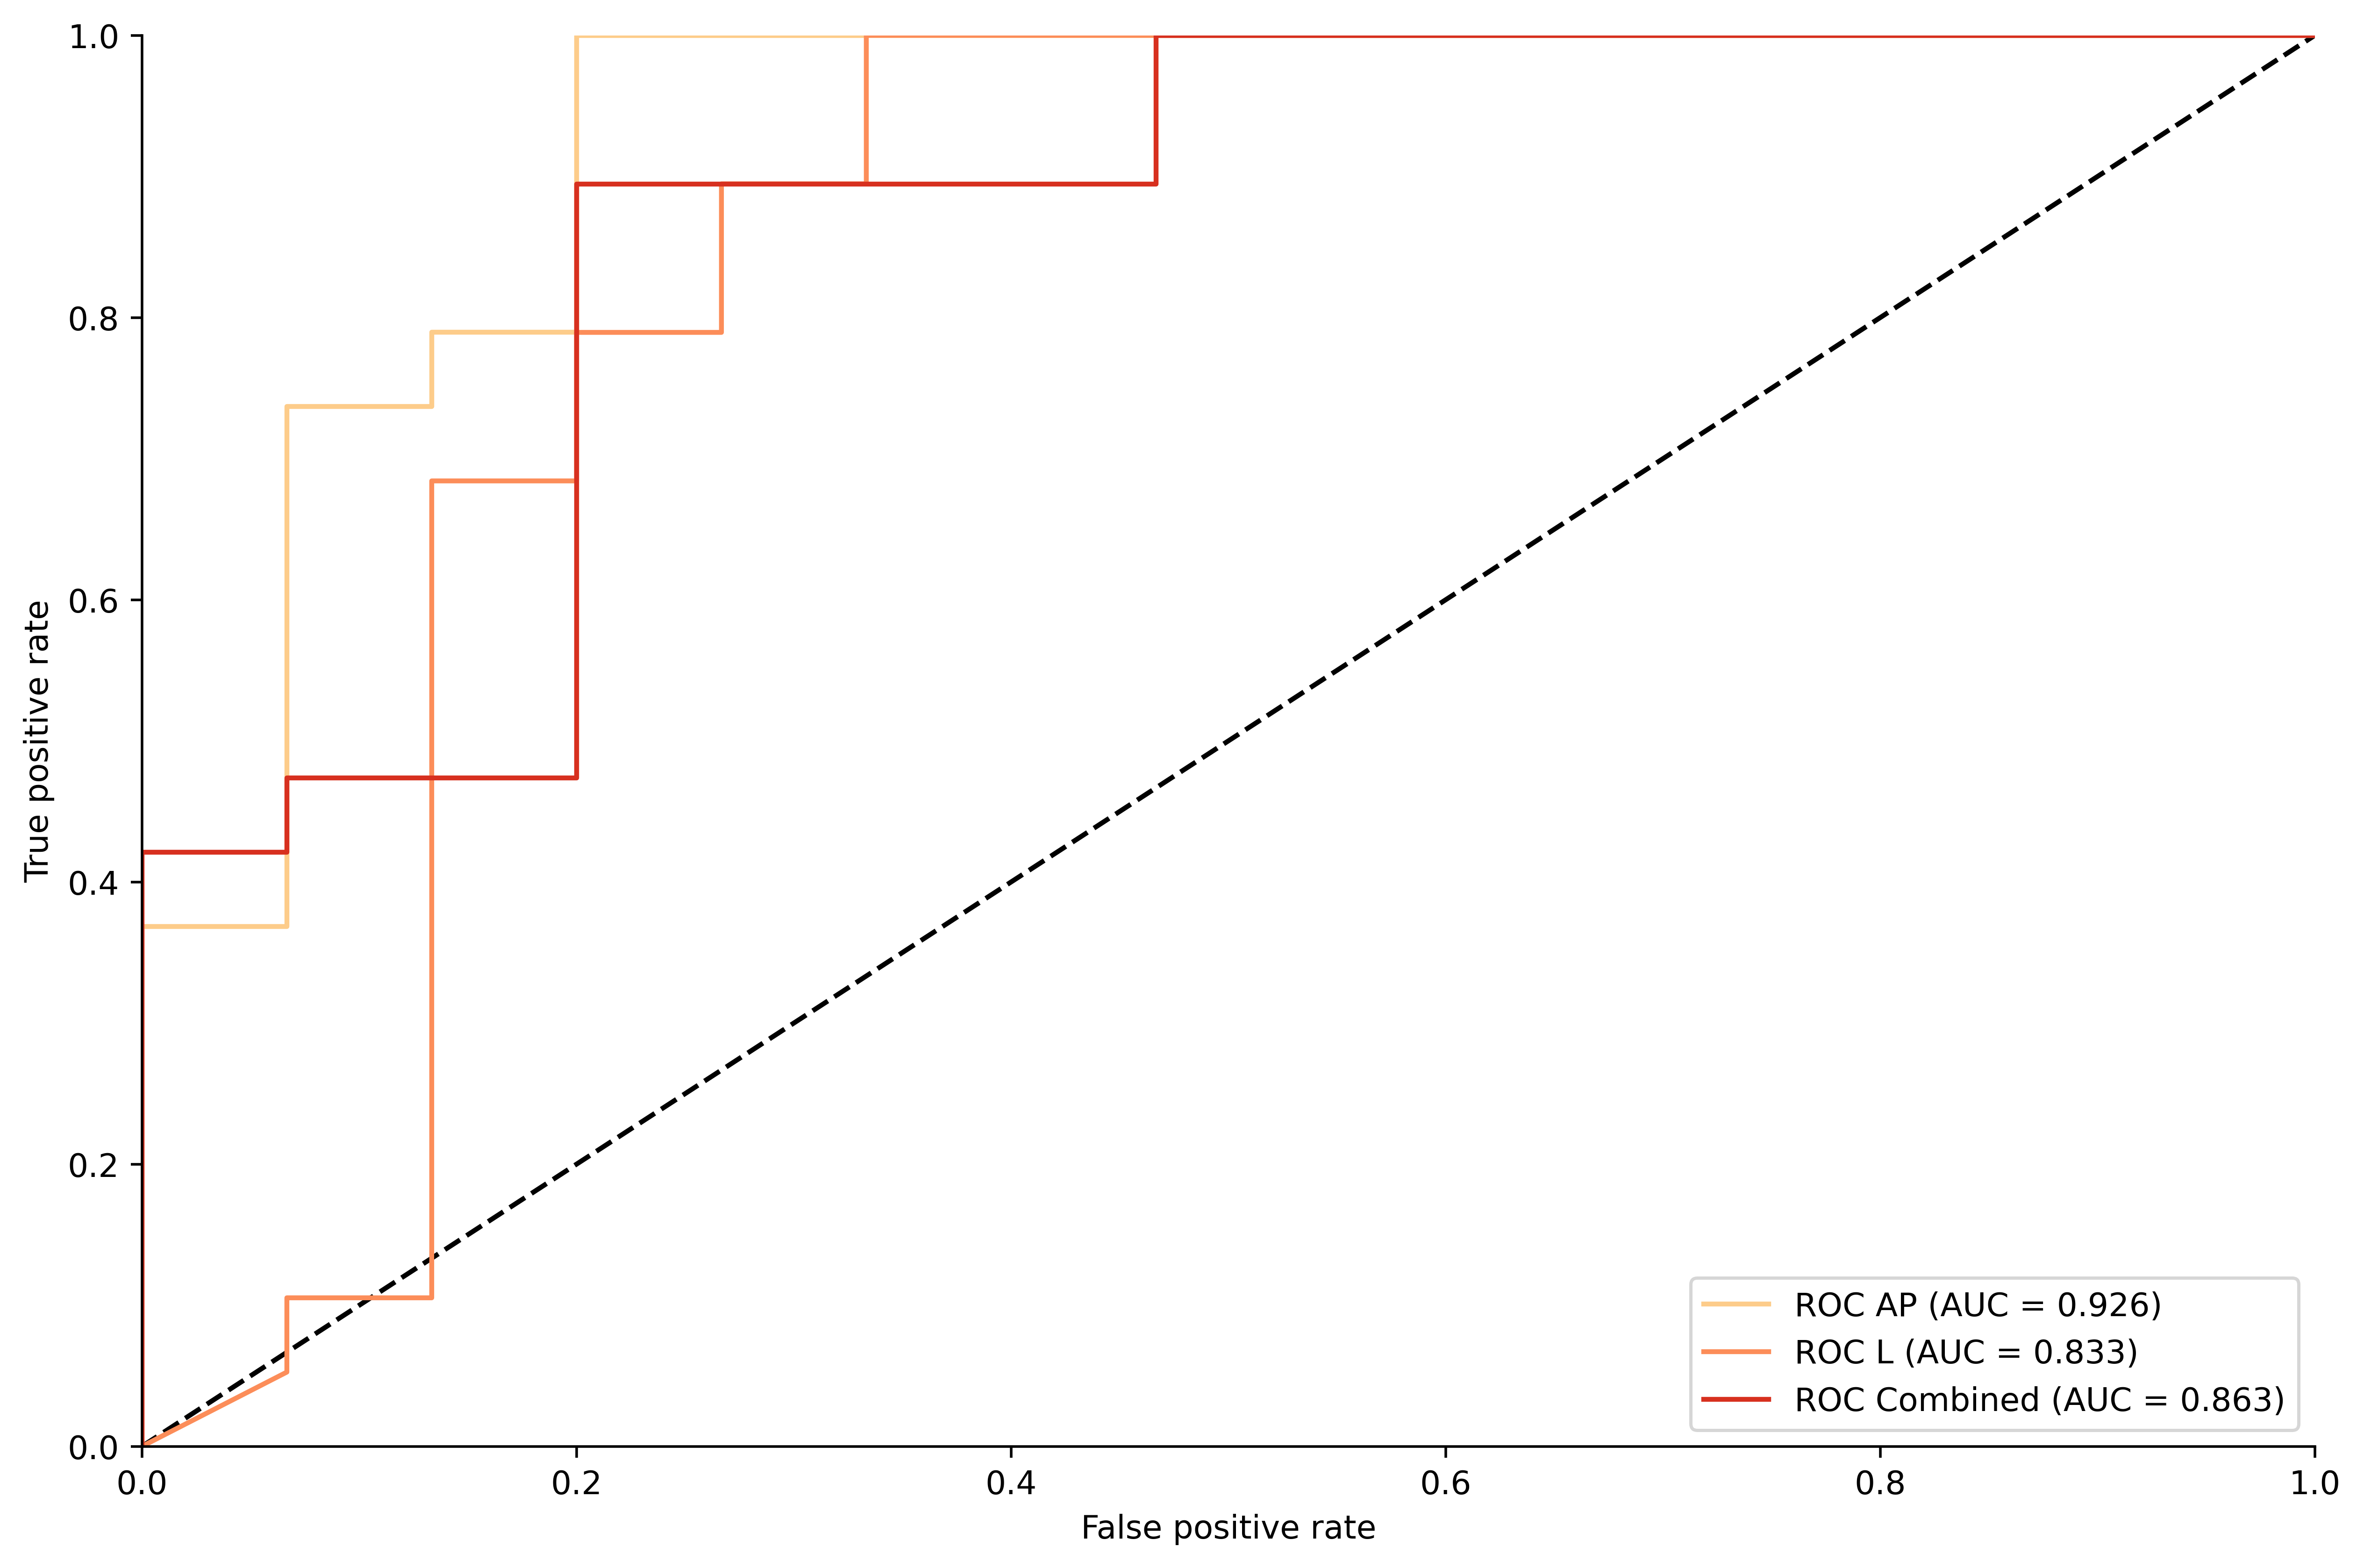

In [ ]:
from PIL import Image
import io 
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12,8), dpi=500)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ap, tpr_ap, label='ROC AP (AUC = {:.3f})'.format(auc_ap), color='#fdcc8a')
plt.plot(fpr_L, tpr_L, label='ROC L (AUC = {:.3f})'.format(auc_L), color='#fc8d59')
plt.plot(fpr_combined, tpr_combined, label='ROC Combined (AUC = {:.3f})'.format(auc_combined), color='#d7301f')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('ROC Combined AP & L Curve')
plt.legend(loc='best')
plt.show()

png1 = io.BytesIO()
fig.savefig(png1, format='png')

png2 = Image.open(png1)

png2.save("AUROC.tiff")
png1.close()


In [ ]:
precision_ap, recall_ap, thresholds_ap = precision_recall_curve(y_test, y_pred_ap)

precision_L, recall_L, thresholds_L = precision_recall_curve(y_test, y_pred_L)

precision_combined, recall_combined, thresholds_combined = precision_recall_curve(y_test, y_pred)


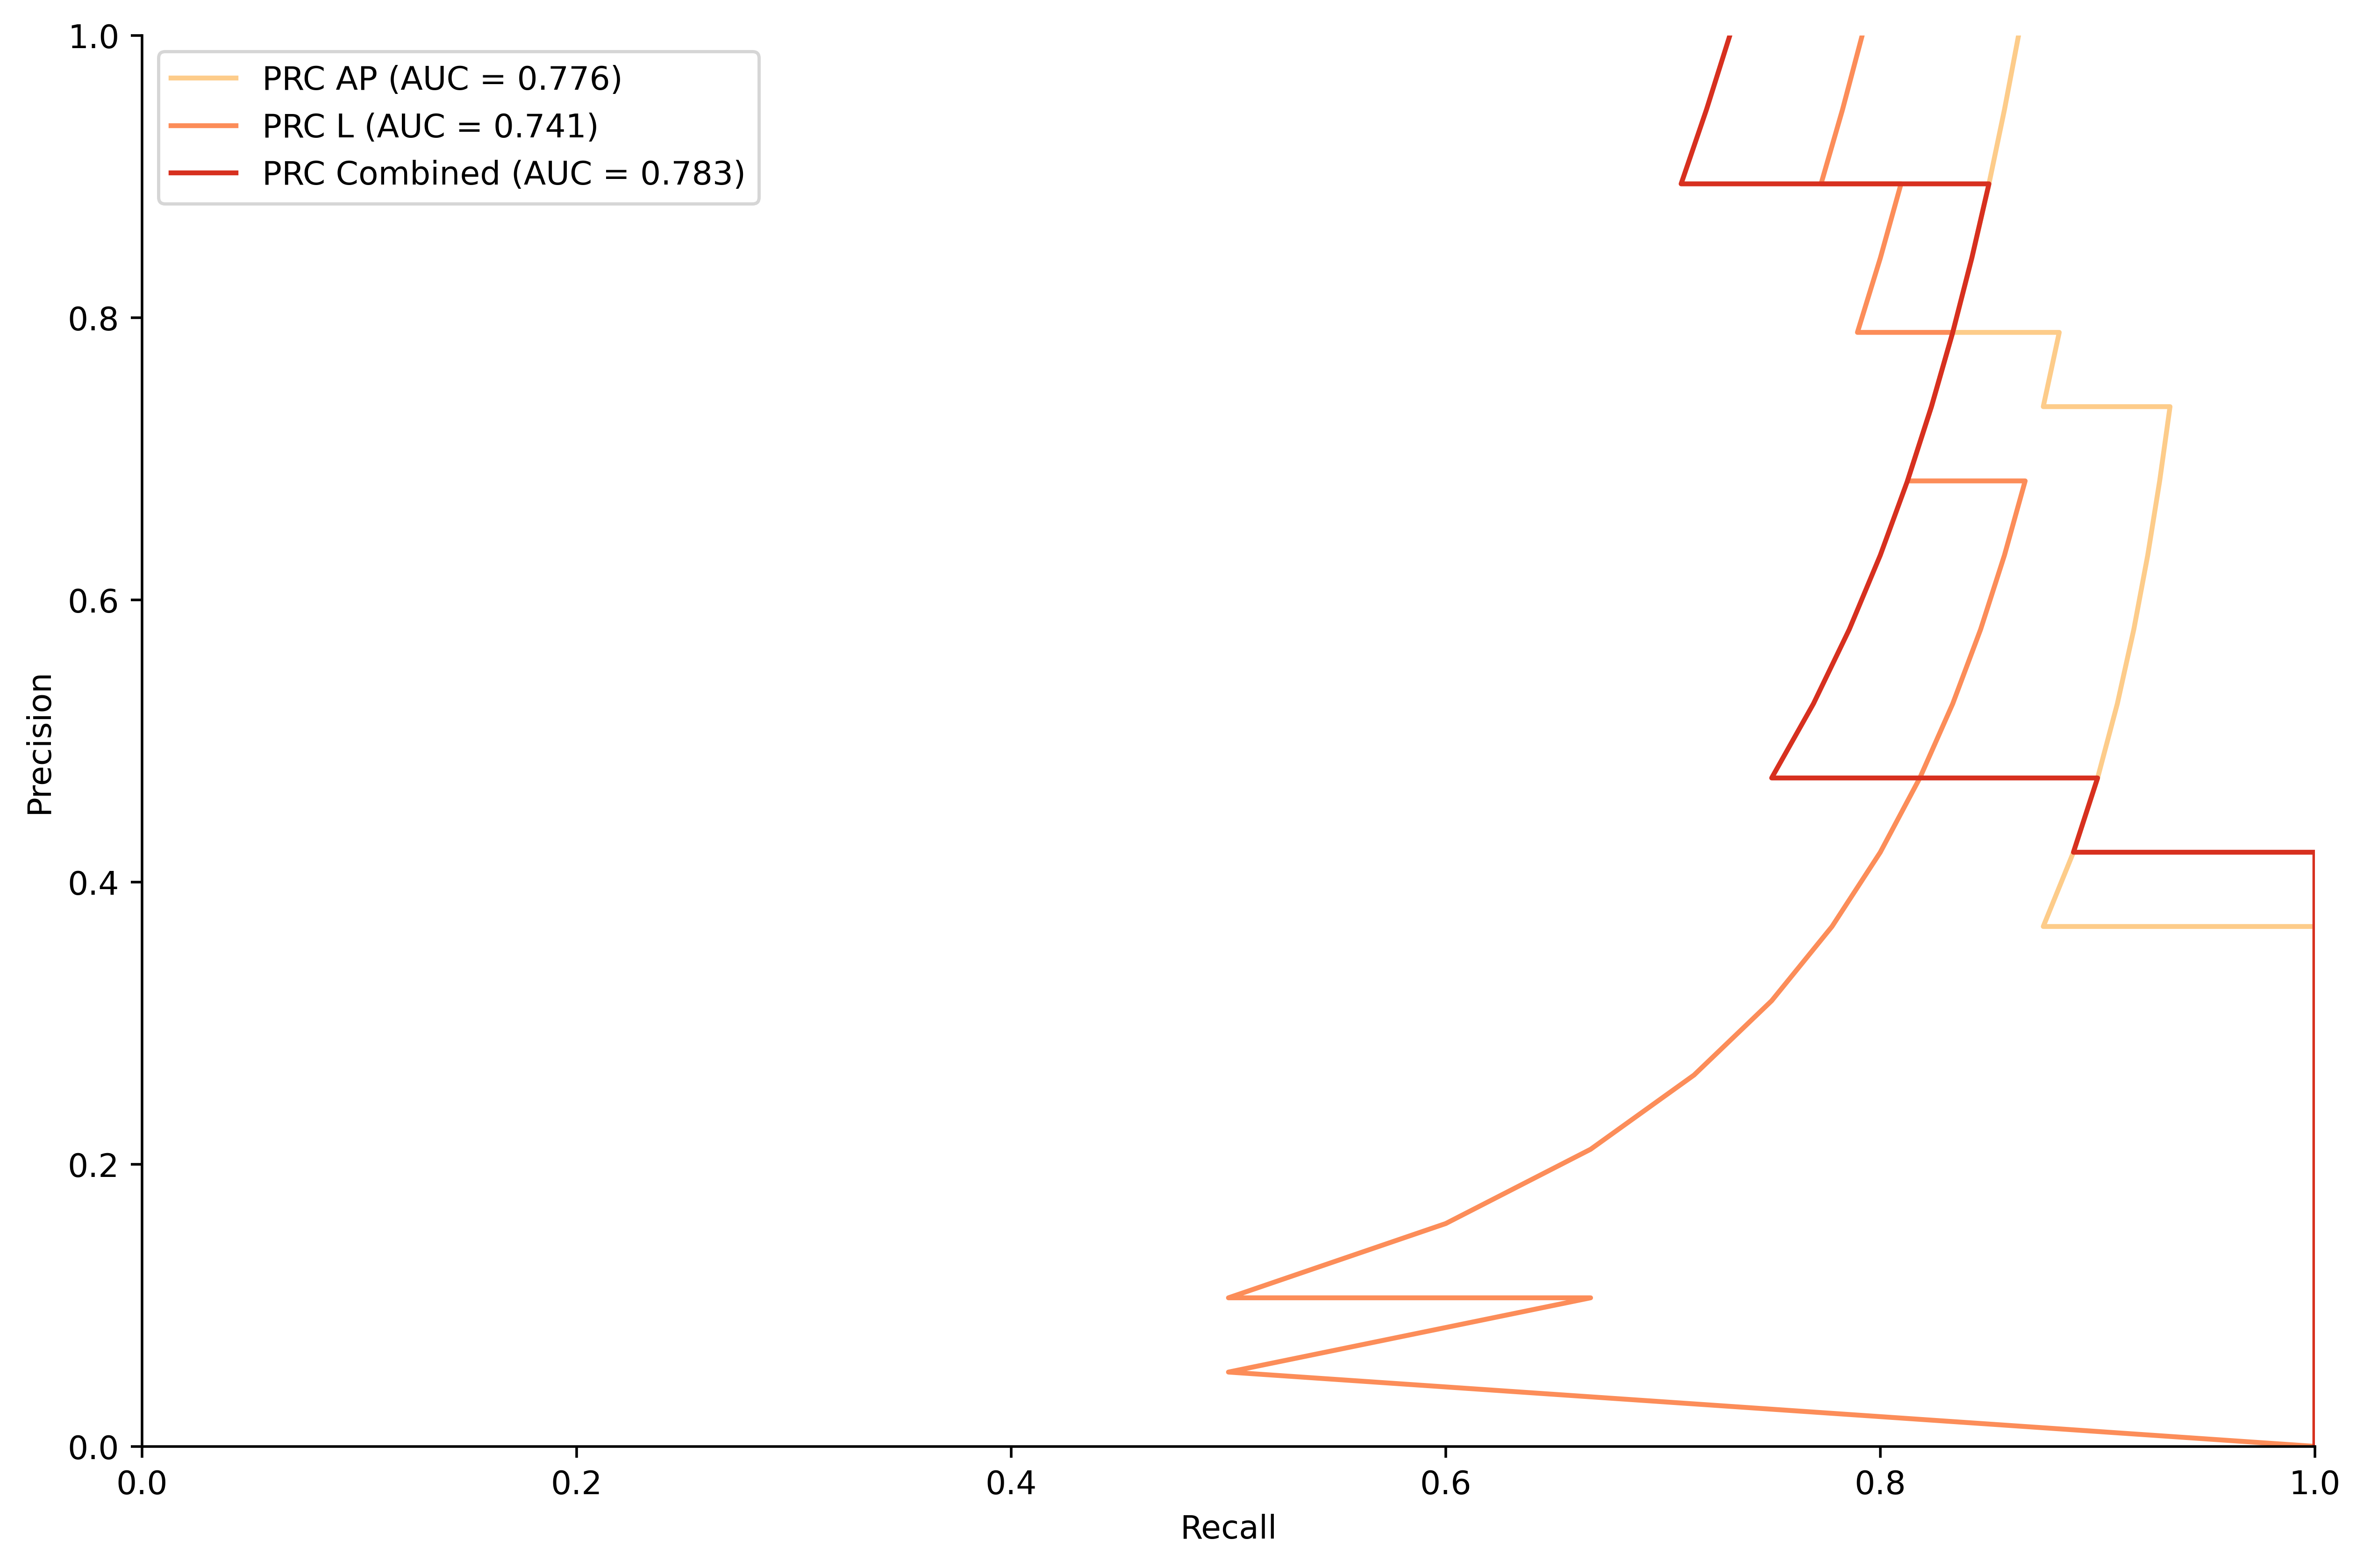

In [ ]:
ap_ap = average_precision_score(y_test, y_pred_ap_rounded)
ap_L =  average_precision_score(y_test, y_pred_L_rounded )
ap_combined =  average_precision_score(y_test, y_pred_rounded)



fig = plt.figure(figsize=(12,8), dpi=500)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(precision_ap, recall_ap, label='PRC AP (AUC = {:.3f})'.format(ap_ap), color='#fdcc8a')
plt.plot(precision_L, recall_L, label='PRC L (AUC = {:.3f})'.format(ap_L), color='#fc8d59')
plt.plot(precision_combined, recall_combined, label='PRC Combined (AUC = {:.3f})'.format(ap_combined), color='#d7301f')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

png1 = io.BytesIO()
fig.savefig(png1, format='png')

png2 = Image.open(png1)

png2.save("AUPRC.tiff")
png1.close()
